In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

from configs import *
from metrics import *
from models import dfNN, dfNN_aux, NN, NN_aux

# setting device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# overwrite if needed: # device = 'cpu'
print('Using device:', device)
print()

Using device: cuda



In [2]:
### TRAIN ###
train = torch.load("data/train_test_tensors/train_tensor.pt", weights_only = False)
train = train.T
train = train[::SUBSAMPLE_RATE, :]

x_train = train[:, :3].to(device)
print("x_train shape:", x_train.shape)
y_train = train[:, 3:5].to(device)
print("y_train shape:", y_train.shape)
print()

### TEST ###
test = torch.load("data/train_test_tensors/test_tensor.pt", weights_only = False)
test = test.T
test = test[::SUBSAMPLE_RATE, :]

x_test = test[:, :3].to(device)
print("x_test shape:", x_test.shape)
y_test = test[:, 3:5].to(device)
print("y_test shape:", y_test.shape)

x_train shape: torch.Size([27172, 3])
y_train shape: torch.Size([27172, 2])

x_test shape: torch.Size([22045, 3])
y_test shape: torch.Size([22045, 2])


In [ ]:
model_name = "dfNN_xs"
print("Model - ", model_name)

PRINT_FREQUENCY = 10

# convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

model = dfNN_aux().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = dfNN_LR, weight_decay = WEIGHT_DECAY)

MAX_NUM_EPOCHS = 400
# At 400 it was best

train_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
test_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

# Early stopping variables
best_epoch_loss = float('inf')
# counter starts at 0
epochs_no_improve = 0

########################
### LOOP over EPOCHS ###
########################

for run in range(NUM_RUNS):

    for epoch in range(MAX_NUM_EPOCHS):

        model.train()
        optimizer.zero_grad()

        # accumulate losses over batches for each epoch 
        train_losses_RMSE_over_batches = 0.0

        #########################
        ### LOOP over BATCHES ###
        #########################

        for x_batch, y_batch in dataloader:

            # Move batch to device and enable gradient tracking for x_batch
            x_batch = x_batch.to(device).requires_grad_(True)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = torch.mean((output - y_batch) ** 2)
            loss.backward()
            optimizer.step()

            # Add losses to the epoch loss (over batches)
            train_losses_RMSE_over_batches += loss.item()

        #############################
        ### END LOOP over BATCHES ###
        #############################
        
        avg_train_loss_RMSE_for_epoch = train_losses_RMSE_over_batches / len(dataloader)
        train_losses_RMSE_over_epochs[epoch] = avg_train_loss_RMSE_for_epoch

        # Early stopping check
        if avg_train_loss_RMSE_for_epoch < best_epoch_loss:
            best_loss = avg_train_loss_RMSE_for_epoch
            epochs_no_improve = 0  # reset counter
            best_model_state = model.state_dict()  # save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # EVALUATE ON TEST SET
        model.eval()

        y_pred = model(x_test.requires_grad_(True).to(device))

        RMSE = compute_RMSE(y_test, y_pred)
        MAE = compute_MAE(y_test, y_pred)

        test_losses_RMSE_over_epochs[epoch] = RMSE.item()

        # Print loss every epoch
        if epoch % PRINT_FREQUENCY == 0 or epoch == MAX_NUM_EPOCHS - 1:
            print(f"Epoch {epoch} | Loss (Train RMSE): {avg_train_loss_RMSE_for_epoch:.3f}")
            print(f"Epoch {epoch} | Test RMSE: {RMSE:.3f}, Test MAE: {MAE:.3f}")

    ############################
    ### END LOOP over EPOCHS ###
    ############################

    # Save best model
    torch.save(best_model_state, f"trained_model/dfNN/{model_name}_epochs_{MAX_NUM_EPOCHS + 1}_run_{run + 1}.pth")
    print("Best model saved.")

    torch.save({
        "train_RMSE": train_losses_RMSE_over_epochs,
        "test_RMSE": test_losses_RMSE_over_epochs
    }, f"trained_model/dfNN/{model_name}_loss_curves_epochs_{MAX_NUM_EPOCHS + 1}_run_{run + 1}.pt")

    # Create a new instance of the model (with same architecture)
    trained_model = dfNN_aux().to(device)

    # Load the saved state dict
    trained_model.load_state_dict(best_model_state)

    # Set to eval mode
    trained_model.eval()

    y_pred = trained_model(x_test.requires_grad_(True).to(device))

    RMSE = compute_RMSE(y_test, y_pred)
    MAE = compute_MAE(y_test, y_pred)
    print(f"RMSE: {RMSE:.6f}, MAE: {MAE:.6f}")

    torch.save({
        "model_name": model_name,
        "run": run + 1,
        "epochs": epoch + 1,
        "RMSE": RMSE.item(),
        "MAE": MAE.item()
    }, f"trained_model/dfNN/{model_name}_metrics_run_{run}.pt")

##########################
### END LOOP over RUNS ###
##########################

Epoch 0 | Loss: 7.412012
Test RMSE: 1.701699, Test MAE: 0.978305
Epoch 1 | Loss: 4.077762
Test RMSE: 1.415777, Test MAE: 0.841798
Epoch 2 | Loss: 3.191177
Test RMSE: 1.356826, Test MAE: 0.785765
Epoch 3 | Loss: 2.954645
Test RMSE: 1.344276, Test MAE: 0.757080
Epoch 4 | Loss: 2.787398
Test RMSE: 1.271343, Test MAE: 0.666400
Epoch 5 | Loss: 2.480901
Test RMSE: 1.281459, Test MAE: 0.623674
Epoch 6 | Loss: 1.322104
Test RMSE: 0.956356, Test MAE: 0.517490
Epoch 7 | Loss: 0.634577
Test RMSE: 0.847733, Test MAE: 0.443930
Epoch 8 | Loss: 0.497291
Test RMSE: 0.742368, Test MAE: 0.404064
Epoch 9 | Loss: 0.511289
Test RMSE: 0.764673, Test MAE: 0.405190
Epoch 10 | Loss: 0.464862
Test RMSE: 0.688196, Test MAE: 0.372664
Epoch 11 | Loss: 0.424191
Test RMSE: 0.695381, Test MAE: 0.381192
Epoch 12 | Loss: 0.410049
Test RMSE: 0.671471, Test MAE: 0.372303
Epoch 13 | Loss: 0.392444
Test RMSE: 0.676454, Test MAE: 0.371958
Epoch 14 | Loss: 0.390285
Test RMSE: 0.629932, Test MAE: 0.350199
Epoch 15 | Loss: 0.3

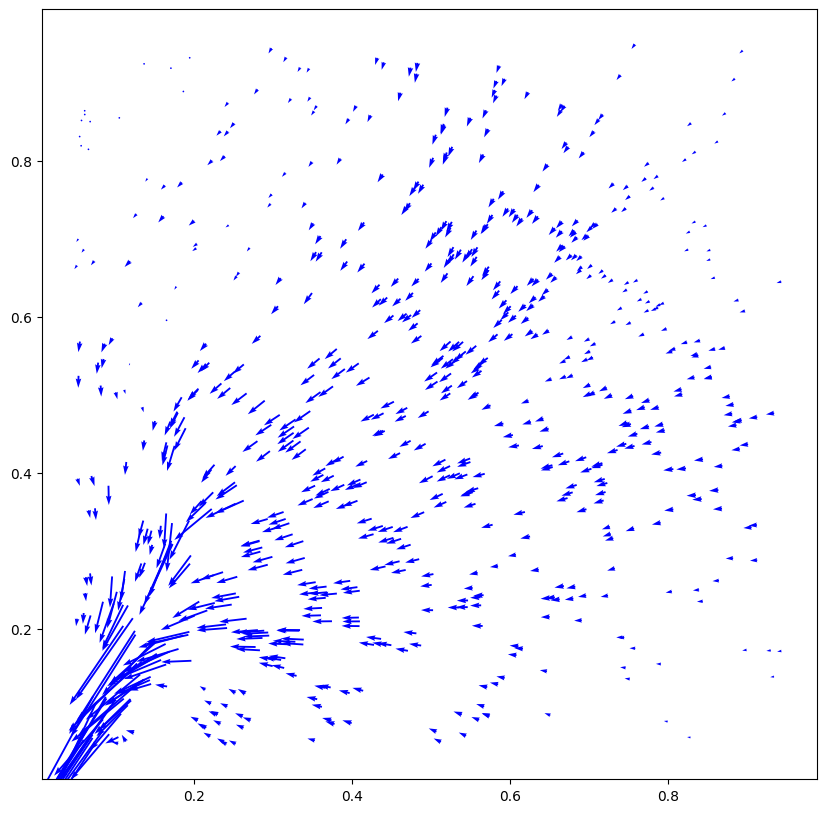

In [53]:
VIS_SUBSAMPLE_RATE = 30

plt.figure(figsize = (10, 10))
plt.quiver(
    x_test[::VIS_SUBSAMPLE_RATE, 0].cpu().detach().numpy(),
    x_test[::VIS_SUBSAMPLE_RATE, 1].cpu().detach().numpy(),
    y_pred[::VIS_SUBSAMPLE_RATE, 0].cpu().detach().numpy(),
    y_pred[::VIS_SUBSAMPLE_RATE, 1].cpu().detach().numpy(),
    color = 'blue'
)

# Insepct H

In [ ]:
x = torch.linspace(start = 0, end = 1, steps = 200) 
torch.meshgrid(x, x, indexing = 'ij')

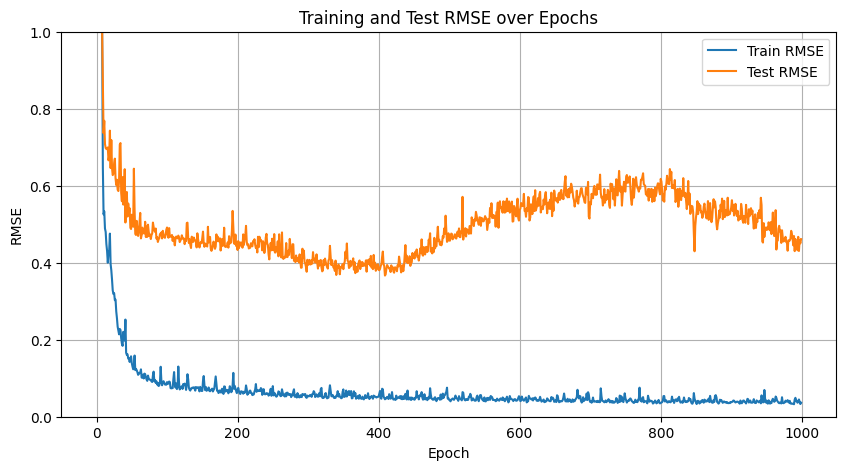

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(train_losses_RMSE_over_epochs[:epoch + 1], label = 'Train RMSE')
plt.plot(test_losses_RMSE_over_epochs[:epoch + 1], label = 'Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title(f'Training and Test RMSE over Epochs - {model_name}')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

# Location input

In [ ]:
x_train = x_train[:, :2]
print("x_train shape after slicing:", x_train.shape)

x_test = x_test[:, :2]
print("x_test shape after slicing:", x_test.shape)

torch.Size([22045, 2])

In [ ]:
model_name = "dfNN_x"
print("Model - ", model_name)

PRINT_FREQUENCY = 10

# NOTE: Remove surface elevation from input tensors
x_train = x_train[:, :2]
print("x_train shape after slicing:", x_train.shape)

x_test = x_test[:, :2]
print("x_test shape after slicing:", x_test.shape)

# convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

# NOTE: specify the model architecture
model = dfNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = dfNN_LR, weight_decay = WEIGHT_DECAY)

MAX_NUM_EPOCHS = 400
# At 400 it was best

train_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
test_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

# Early stopping variables
best_epoch_loss = float('inf')
# counter starts at 0
epochs_no_improve = 0

########################
### LOOP over EPOCHS ###
########################

for run in range(NUM_RUNS):

    for epoch in range(MAX_NUM_EPOCHS):

        model.train()
        optimizer.zero_grad()

        # accumulate losses over batches for each epoch 
        train_losses_RMSE_over_batches = 0.0

        #########################
        ### LOOP over BATCHES ###
        #########################

        for x_batch, y_batch in dataloader:

            # Move batch to device and enable gradient tracking for x_batch
            x_batch = x_batch.to(device).requires_grad_(True)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = torch.mean((output - y_batch) ** 2)
            loss.backward()
            optimizer.step()

            # Add losses to the epoch loss (over batches)
            train_losses_RMSE_over_batches += loss.item()

        #############################
        ### END LOOP over BATCHES ###
        #############################
        
        avg_train_loss_RMSE_for_epoch = train_losses_RMSE_over_batches / len(dataloader)
        train_losses_RMSE_over_epochs[epoch] = avg_train_loss_RMSE_for_epoch

        # Early stopping check
        if avg_train_loss_RMSE_for_epoch < best_epoch_loss:
            best_loss = avg_train_loss_RMSE_for_epoch
            epochs_no_improve = 0  # reset counter
            best_model_state = model.state_dict()  # save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # EVALUATE ON TEST SET
        model.eval()

        y_pred = model(x_test.requires_grad_(True).to(device))

        RMSE = compute_RMSE(y_test, y_pred)
        MAE = compute_MAE(y_test, y_pred)

        test_losses_RMSE_over_epochs[epoch] = RMSE.item()

        # Print loss every epoch
        if epoch % PRINT_FREQUENCY == 0 or epoch == MAX_NUM_EPOCHS - 1:
            print(f"Epoch {epoch} | Loss (Train RMSE): {avg_train_loss_RMSE_for_epoch:.3f}")
            print(f"Epoch {epoch} | Test RMSE: {RMSE:.3f}, Test MAE: {MAE:.3f}")

    ############################
    ### END LOOP over EPOCHS ###
    ############################

    # Save best model
    torch.save(best_model_state, f"trained_model/dfNN/{model_name}_epochs_{MAX_NUM_EPOCHS + 1}_run_{run + 1}.pth")
    print("Best model saved.")

    torch.save({
        "train_RMSE": train_losses_RMSE_over_epochs,
        "test_RMSE": test_losses_RMSE_over_epochs
    }, f"trained_model/dfNN/{model_name}_loss_curves_epochs_{MAX_NUM_EPOCHS + 1}_run_{run + 1}.pt")

    # Create a new instance of the model (with same architecture)
    # NOTE: Change to dfNN if needed
    trained_model = dfNN().to(device)

    # Load the saved state dict
    trained_model.load_state_dict(best_model_state)

    # Set to eval mode
    trained_model.eval()

    y_pred = trained_model(x_test.requires_grad_(True).to(device))

    RMSE = compute_RMSE(y_test, y_pred)
    MAE = compute_MAE(y_test, y_pred)
    print(f"RMSE: {RMSE:.6f}, MAE: {MAE:.6f}")

    torch.save({
        "model_name": model_name,
        "run": run + 1,
        "epochs": epoch + 1,
        "RMSE": RMSE.item(),
        "MAE": MAE.item()
    }, f"trained_model/dfNN/{model_name}_metrics_run_{run}.pt")

##########################
### END LOOP over RUNS ###
##########################

Model -  dfNN_x
x_train shape after slicing: torch.Size([27172, 2])
x_test shape after slicing: torch.Size([22045, 2])


Epoch 0 | Loss (Train RMSE): 7.681
Epoch 0 | Test RMSE: 1.904, Test MAE: 1.188
Epoch 10 | Loss (Train RMSE): 0.316
Epoch 10 | Test RMSE: 0.568, Test MAE: 0.309
Epoch 20 | Loss (Train RMSE): 0.270
Epoch 20 | Test RMSE: 0.559, Test MAE: 0.287
Epoch 30 | Loss (Train RMSE): 0.226
Epoch 30 | Test RMSE: 0.489, Test MAE: 0.260
Epoch 40 | Loss (Train RMSE): 0.183
Epoch 40 | Test RMSE: 0.500, Test MAE: 0.265
Epoch 50 | Loss (Train RMSE): 0.157
Epoch 50 | Test RMSE: 0.495, Test MAE: 0.268
Epoch 60 | Loss (Train RMSE): 0.134
Epoch 60 | Test RMSE: 0.409, Test MAE: 0.218
Epoch 70 | Loss (Train RMSE): 0.140
Epoch 70 | Test RMSE: 0.486, Test MAE: 0.245
Epoch 80 | Loss (Train RMSE): 0.116
Epoch 80 | Test RMSE: 0.387, Test MAE: 0.210
Epoch 90 | Loss (Train RMSE): 0.103
Epoch 90 | Test RMSE: 0.388, Test MAE: 0.209
Epoch 100 | Loss (Train RMSE): 0.087
Epoch 100 | Test RMSE: 0.373, Test MAE: 0.195
Epoch 110 | Loss (Train RMSE): 0.086
Epoch 110 | Test RMSE: 0.380, Test MAE: 0.199
Epoch 120 | Loss (Train RM

RuntimeError: Error(s) in loading state_dict for dfNN_aux:
	size mismatch for net.0.weight: copying a param with shape torch.Size([64, 2]) from checkpoint, the shape in current model is torch.Size([64, 3]).

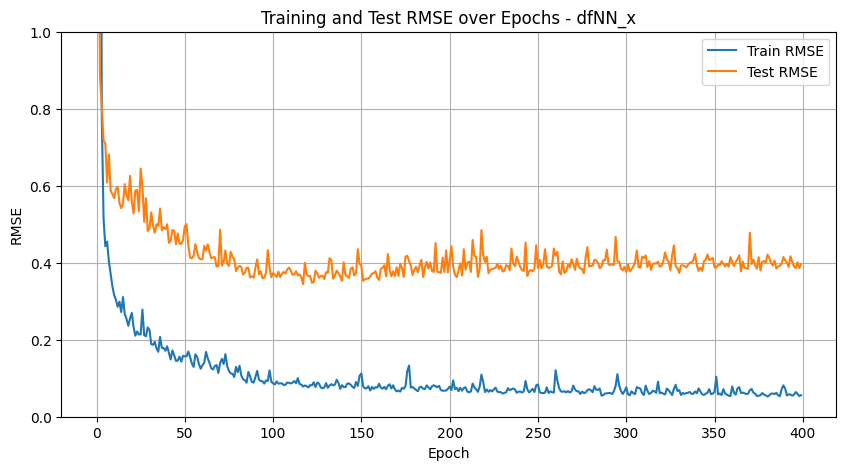

In [58]:
plt.figure(figsize = (10, 5))
plt.plot(train_losses_RMSE_over_epochs[:epoch + 1], label = 'Train RMSE')
plt.plot(test_losses_RMSE_over_epochs[:epoch + 1], label = 'Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title(f'Training and Test RMSE over Epochs - {model_name}')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

In [4]:
model_name = "NN_x"
print("Model - ", model_name)

PRINT_FREQUENCY = 10

# NOTE: Remove surface elevation from input tensors
x_train_only_x = x_train[:, :2]
print("x_train shape after slicing:", x_train_only_x.shape)

x_test_only_x = x_test[:, :2]
print("x_test shape after slicing:", x_test_only_x.shape)

# convert to DataLoader for batching
dataset = TensorDataset(x_train_only_x, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

# NOTE: specify the model architecture
model = NN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = dfNN_LR, weight_decay = WEIGHT_DECAY)

MAX_NUM_EPOCHS = 400
# At 400 it was best

train_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
test_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

# Early stopping variables
best_epoch_loss = float('inf')
# counter starts at 0
epochs_no_improve = 0

########################
### LOOP over EPOCHS ###
########################

for run in range(NUM_RUNS):

    for epoch in range(MAX_NUM_EPOCHS):

        model.train()
        optimizer.zero_grad()

        # accumulate losses over batches for each epoch 
        train_losses_RMSE_over_batches = 0.0

        #########################
        ### LOOP over BATCHES ###
        #########################

        for x_batch, y_batch in dataloader:

            # Move batch to device and enable gradient tracking for x_batch
            x_batch = x_batch.to(device).requires_grad_(True)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = torch.mean((output - y_batch) ** 2)
            loss.backward()
            optimizer.step()

            # Add losses to the epoch loss (over batches)
            train_losses_RMSE_over_batches += loss.item()

        #############################
        ### END LOOP over BATCHES ###
        #############################
        
        avg_train_loss_RMSE_for_epoch = train_losses_RMSE_over_batches / len(dataloader)
        train_losses_RMSE_over_epochs[epoch] = avg_train_loss_RMSE_for_epoch

        # Early stopping check
        if avg_train_loss_RMSE_for_epoch < best_epoch_loss:
            best_loss = avg_train_loss_RMSE_for_epoch
            epochs_no_improve = 0  # reset counter
            best_model_state = model.state_dict()  # save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # EVALUATE ON TEST SET
        model.eval()

        y_pred = model(x_test_only_x.requires_grad_(True).to(device))

        RMSE = compute_RMSE(y_test, y_pred)
        MAE = compute_MAE(y_test, y_pred)

        test_losses_RMSE_over_epochs[epoch] = RMSE.item()

        # Print loss every epoch
        if epoch % PRINT_FREQUENCY == 0 or epoch == MAX_NUM_EPOCHS - 1:
            print(f"Epoch {epoch} | Loss (Train RMSE): {avg_train_loss_RMSE_for_epoch:.3f}")
            print(f"Epoch {epoch} | Test RMSE: {RMSE:.3f}, Test MAE: {MAE:.3f}")

    ############################
    ### END LOOP over EPOCHS ###
    ############################

    # Save best model
    torch.save(best_model_state, f"trained_model/dfNN/{model_name}_epochs_{MAX_NUM_EPOCHS + 1}_run_{run + 1}.pth")
    print("Best model saved.")

    torch.save({
        "train_RMSE": train_losses_RMSE_over_epochs,
        "test_RMSE": test_losses_RMSE_over_epochs
    }, f"trained_model/dfNN/{model_name}_loss_curves_epochs_{MAX_NUM_EPOCHS + 1}_run_{run + 1}.pt")

    # Create a new instance of the model (with same architecture)
    # NOTE: Change to dfNN if needed
    trained_model = NN().to(device)

    # Load the saved state dict
    trained_model.load_state_dict(best_model_state)

    # Set to eval mode
    trained_model.eval()

    y_pred = trained_model(x_test_only_x.requires_grad_(True).to(device))

    RMSE = compute_RMSE(y_test, y_pred)
    MAE = compute_MAE(y_test, y_pred)
    print(f"RMSE: {RMSE:.6f}, MAE: {MAE:.6f}")

    torch.save({
        "model_name": model_name,
        "run": run + 1,
        "epochs": epoch + 1,
        "RMSE": RMSE.item(),
        "MAE": MAE.item()
    }, f"trained_model/dfNN/{model_name}_metrics_run_{run}.pt")

##########################
### END LOOP over RUNS ###
##########################

Model -  NN_x
x_train shape after slicing: torch.Size([27172, 2])
x_test shape after slicing: torch.Size([22045, 2])
Epoch 0 | Loss (Train RMSE): 7.937
Epoch 0 | Test RMSE: 1.982, Test MAE: 1.227
Epoch 10 | Loss (Train RMSE): 0.281
Epoch 10 | Test RMSE: 0.627, Test MAE: 0.339
Epoch 20 | Loss (Train RMSE): 0.249
Epoch 20 | Test RMSE: 0.577, Test MAE: 0.299
Epoch 30 | Loss (Train RMSE): 0.215
Epoch 30 | Test RMSE: 0.631, Test MAE: 0.319
Epoch 40 | Loss (Train RMSE): 0.166
Epoch 40 | Test RMSE: 0.588, Test MAE: 0.288
Epoch 50 | Loss (Train RMSE): 0.148
Epoch 50 | Test RMSE: 0.509, Test MAE: 0.255
Epoch 60 | Loss (Train RMSE): 0.167
Epoch 60 | Test RMSE: 0.531, Test MAE: 0.257
Epoch 70 | Loss (Train RMSE): 0.123
Epoch 70 | Test RMSE: 0.539, Test MAE: 0.261
Epoch 80 | Loss (Train RMSE): 0.117
Epoch 80 | Test RMSE: 0.463, Test MAE: 0.230
Epoch 90 | Loss (Train RMSE): 0.113
Epoch 90 | Test RMSE: 0.496, Test MAE: 0.246
Epoch 100 | Loss (Train RMSE): 0.114
Epoch 100 | Test RMSE: 0.469, Test MAE

In [5]:
model_name = "NN_xs"
print("Model - ", model_name)

PRINT_FREQUENCY = 10

# convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

# NOTE: specify the model architecture
model = NN_aux().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = dfNN_LR, weight_decay = WEIGHT_DECAY)

MAX_NUM_EPOCHS = 400
# At 400 it was best

train_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)
test_losses_RMSE_over_epochs = torch.zeros(MAX_NUM_EPOCHS)

# Early stopping variables
best_epoch_loss = float('inf')
# counter starts at 0
epochs_no_improve = 0

########################
### LOOP over EPOCHS ###
########################

for run in range(NUM_RUNS):

    for epoch in range(MAX_NUM_EPOCHS):

        model.train()
        optimizer.zero_grad()

        # accumulate losses over batches for each epoch 
        train_losses_RMSE_over_batches = 0.0

        #########################
        ### LOOP over BATCHES ###
        #########################

        for x_batch, y_batch in dataloader:

            # Move batch to device and enable gradient tracking for x_batch
            x_batch = x_batch.to(device).requires_grad_(True)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = torch.mean((output - y_batch) ** 2)
            loss.backward()
            optimizer.step()

            # Add losses to the epoch loss (over batches)
            train_losses_RMSE_over_batches += loss.item()

        #############################
        ### END LOOP over BATCHES ###
        #############################
        
        avg_train_loss_RMSE_for_epoch = train_losses_RMSE_over_batches / len(dataloader)
        train_losses_RMSE_over_epochs[epoch] = avg_train_loss_RMSE_for_epoch

        # Early stopping check
        if avg_train_loss_RMSE_for_epoch < best_epoch_loss:
            best_loss = avg_train_loss_RMSE_for_epoch
            epochs_no_improve = 0  # reset counter
            best_model_state = model.state_dict()  # save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # EVALUATE ON TEST SET
        model.eval()

        y_pred = model(x_test.requires_grad_(True).to(device))

        RMSE = compute_RMSE(y_test, y_pred)
        MAE = compute_MAE(y_test, y_pred)

        test_losses_RMSE_over_epochs[epoch] = RMSE.item()

        # Print loss every epoch
        if epoch % PRINT_FREQUENCY == 0 or epoch == MAX_NUM_EPOCHS - 1:
            print(f"Epoch {epoch} | Loss (Train RMSE): {avg_train_loss_RMSE_for_epoch:.3f}")
            print(f"Epoch {epoch} | Test RMSE: {RMSE:.3f}, Test MAE: {MAE:.3f}")

    ############################
    ### END LOOP over EPOCHS ###
    ############################

    # Save best model
    torch.save(best_model_state, f"trained_model/dfNN/{model_name}_epochs_{MAX_NUM_EPOCHS + 1}_run_{run + 1}.pth")
    print("Best model saved.")

    torch.save({
        "train_RMSE": train_losses_RMSE_over_epochs,
        "test_RMSE": test_losses_RMSE_over_epochs
    }, f"trained_model/dfNN/{model_name}_loss_curves_epochs_{MAX_NUM_EPOCHS + 1}_run_{run + 1}.pt")

    # Create a new instance of the model (with same architecture)
    # NOTE: Change to dfNN if needed
    trained_model = NN_aux().to(device)

    # Load the saved state dict
    trained_model.load_state_dict(best_model_state)

    # Set to eval mode
    trained_model.eval()

    y_pred = trained_model(x_test.requires_grad_(True).to(device))

    RMSE = compute_RMSE(y_test, y_pred)
    MAE = compute_MAE(y_test, y_pred)
    print(f"RMSE: {RMSE:.6f}, MAE: {MAE:.6f}")

    torch.save({
        "model_name": model_name,
        "run": run + 1,
        "epochs": epoch + 1,
        "RMSE": RMSE.item(),
        "MAE": MAE.item()
    }, f"trained_model/dfNN/{model_name}_metrics_run_{run}.pt")

##########################
### END LOOP over RUNS ###
##########################

Model -  NN_xs
Epoch 0 | Loss (Train RMSE): 7.845
Epoch 0 | Test RMSE: 1.830, Test MAE: 1.063
Epoch 10 | Loss (Train RMSE): 0.604
Epoch 10 | Test RMSE: 0.927, Test MAE: 0.378
Epoch 20 | Loss (Train RMSE): 0.279
Epoch 20 | Test RMSE: 0.641, Test MAE: 0.320
Epoch 30 | Loss (Train RMSE): 0.190
Epoch 30 | Test RMSE: 0.567, Test MAE: 0.261
Epoch 40 | Loss (Train RMSE): 0.155
Epoch 40 | Test RMSE: 0.524, Test MAE: 0.237
Epoch 50 | Loss (Train RMSE): 0.166
Epoch 50 | Test RMSE: 0.550, Test MAE: 0.260
Epoch 60 | Loss (Train RMSE): 0.143
Epoch 60 | Test RMSE: 0.539, Test MAE: 0.245
Epoch 70 | Loss (Train RMSE): 0.133
Epoch 70 | Test RMSE: 0.513, Test MAE: 0.236
Epoch 80 | Loss (Train RMSE): 0.116
Epoch 80 | Test RMSE: 0.517, Test MAE: 0.228
Epoch 90 | Loss (Train RMSE): 0.122
Epoch 90 | Test RMSE: 0.533, Test MAE: 0.253
Epoch 100 | Loss (Train RMSE): 0.111
Epoch 100 | Test RMSE: 0.506, Test MAE: 0.244
Epoch 110 | Loss (Train RMSE): 0.098
Epoch 110 | Test RMSE: 0.490, Test MAE: 0.221
Epoch 120 |

# Todo

- smaller lr
- surface slope rather then surface (or in addition - this doesn't help much)